In [1]:
import os
import sys
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()

from src.text.epu import *
from src.text.gui import DrawTopics
from src.google_trends import GT
from dotenv import load_dotenv
load_dotenv()

from bokeh.plotting import figure, show, output_notebook, from_networkx, output_file
from bokeh.models import (Select, HoverTool, TapTool, BoxSelectTool, Legend,
                          Range1d, Circle, MultiLine)
from bokeh.palettes import Category20
import networkx as nx
from src.text.gui import DrawTopics
output_notebook()

Loading BokehJS ...

## EPU

In [90]:
GoogleAPIkey = os.getenv("GoogleAPIkey")
gt = GT(GoogleAPIkey)

words = ["inflation", "cpi", "food price", "living costs"]
dnx = DrawTopics(words, "PG", gt)
dnx.trends_to_nx_object()
p = dnx.make_graph()
show(p)

In [49]:
dnx.result[dnx.result["volume"] >= 5]["target"].unique()

array(['inflation', 'economy', 'rate', 'economics', 'unemployment',
       'inflation rate', 'policy', 'price', 'government', 'money',
       'interest', 'demand', 'cost', 'gross domestic product',
       'interest rate', 'country', 'supply', 'monetary policy',
       'calculation', 'goods', 'market', 'market economy', 'system',
       'coronavirus disease 2019', 'exchange rate', 'bsp',
       'papua new guinean kina', 'united states dollar',
       'bangko sentral ng pilipinas', 'calculator', 'currency',
       'australian dollar', 'production', 'unemployment rate',
       'employment', 'wage', 'poverty', 'letter', 'letter of intent',
       'writing', 'cover letter', 'loan', 'compound interest', 'formula',
       'application for employment', 'deposit', 'simple interest',
       'investment', 'supply and demand', 'elasticity',
       'price elasticity of demand', 'curve', 'demand curve', 'income',
       'accounting', 'savings', 'finance', 'savings account',
       'power supply', 'w

In [4]:
target_dir = os.getcwd() + "/outputs/text/png/"
news_dir = os.getcwd() + "/data/text/papua_new_guinea/"

epu_df = pd.DataFrame()
filepaths = [news_dir + file for file in os.listdir(news_dir)
             if "news" in file]

In [76]:
additional_terms = [
    'inflation',
    'cpi',
    'price',
    'prices',
    'economy',
    'expense',
    'budget',
    'income',
    'demand',
    'cost',
    'costs',
    'poverty',
    'supply',
    'goods',
    'trade',
    'wage',
    'food',
    'electricity',
    'purchasing',
    'payment',
    'rent',
    'minimum wage',
    'price index',
    'price elasticity of supply',
    'inflation rate',
    'interest rate',
    'cost-push inflation',
    'salary',
    'forecasting',
    'payment',
    'sales',
    'clothing',
    'product',
    'living',
]

epu = EPU(filepaths, "2020-01-01", additional_terms=additional_terms)
epu.get_epu_category(subset_condition="date > '2015-01-01'")
epu.get_count_stats()
epu.calculate_epu_score()

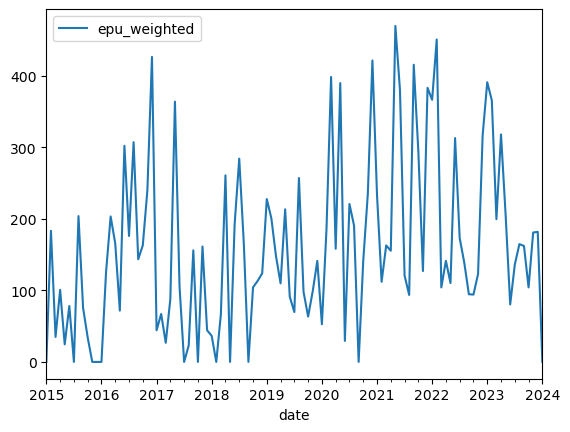

In [77]:
epu.epu_stats.plot(x="date", y="epu_weighted");

In [81]:
epu_df = epu.epu_stats.set_index("date").resample("Q")[["epu_weighted"]].mean().reset_index()
cpi_list = [
    115.5, 116.8, 118.7, 121.0, 123.0, 124.7, 126.8, 129.0, 130.4, 132.1,
    133.3, 135.1, 135.7, 137.5, 139.3, 141.5, 142.5, 143.4, 144.5, 145.4,
    146.9, 152.5, 151.5, 152.9, 153.8, 157.5, 158.0, 161.6, 162.9, 166.2,
    167.9, 167.1, 165.6, 168.5, 171.6
]
cpi_df = pd.DataFrame(cpi_list, columns=["cpi"])
cpi_df["date"] = pd.date_range(start="2015-01-01", periods=len(cpi_list), freq="Q")
cpi_df = cpi_df.merge(epu_df)
cpi_df["inflation"] = (cpi_df["cpi"].diff()*100)/cpi_df["cpi"].shift(1)
cpi_df["epu_change"] = (cpi_df["epu_weighted"].diff()*100)/cpi_df["epu_weighted"].shift(1)

<AxesSubplot:xlabel='lags'>

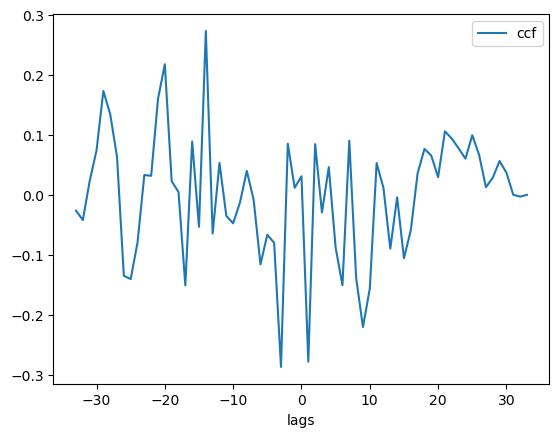

In [82]:
from src.tourism.ts_utils import get_adf_df, cross_correlation

cc_df = cross_correlation(cpi_df.epu_weighted[1:], cpi_df.inflation[1:])
cc_df.plot(x="lags")

In [85]:
get_adf_df(cpi_df.dropna(), ["inflation", "epu_change"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
inflation,-4.559746,0.000153,2.0,31.0,-3.661429,-2.960525,-2.619319
epu_change,-2.335226,0.160858,9.0,24.0,-3.737709,-2.992216,-2.635747


In [87]:
from statsmodels.tsa.api import VAR

length = len(cpi_df.iloc[1:])
train = int(length * 0.95)
test = length - train

model = VAR(endog=cpi_df.iloc[1:, [3, 4]])

eval_lst = []
for i in range(1, 10):
    result = model.fit(i)
    eval_metrics = {
        "lag": i,
        "AIC": result.aic,
        "BIC": result.bic,
        "FPE": result.fpe,
        "HQIC": result.hqic
    }
    eval_lst.append(eval_metrics)

eval_df = pd.DataFrame(eval_lst)
eval_df

,lag,AIC,BIC,FPE,HQIC
0,1,10.338886,10.610978,30942.709580,10.430437
1,2,10.522813,10.980856,37345.783302,10.674641
2,3,10.565644,11.213251,39398.474276,10.776747
3,4,9.599124,10.439842,15324.408167,9.868077
4,5,9.352390,10.389649,12483.516963,9.677247
5,6,9.717917,10.954964,19376.526262,10.096094
6,7,9.865758,11.305577,25567.114251,10.293892
7,8,9.735367,11.380570,28224.154162,10.209126
8,9,8.484976,10.337667,12454.489058,8.998834


In [88]:
best_res = model.fit(1)
best_res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Jan, 2024
Time:                     18:02:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.6110
Nobs:                     33.0000    HQIC:                   10.4304
Log likelihood:          -258.242    FPE:                    30942.7
AIC:                      10.3389    Det(Omega_mle):         26000.5
--------------------------------------------------------------------
Results for equation inflation
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 1.340340         0.265899            5.041           0.000
L1.inflation         -0.154450         0.182773           -0.845           0.398
L1.epu_change         0.000300         0.000952         

## GUI

In [9]:


job_words = [
    "job",
    "unemployment",
    "hiring",
    "layoff",
    "job market",
    "job opportunities",
    "job vacancy",
    "job vacancies",
    "job training",
    "job application",
    "unemployment rate",
    "jobs in port moresby",
    "job in port moresby",
    "job in lae",
    "jobs in lae",
]

In [ ]:
target_dir = os.getcwd() + "/outputs/text/png/"
gt = GT(GoogleAPIkey)
for words, name in zip([job_words, inflation_words],
                       ["png_job_graph", "png_price_graph"]):
    dnx = DrawTopics(words, "PG", gt)
    dnx.trends_to_nx_object()
    dnx.result.to_csv(target_dir+name+".csv", encoding="utf-8")
    output_file(filename=target_dir + f"{name}.html")
    p = dnx.make_graph()
    show(p)

job : 0 out of 106 rows with zero values.
unemployment : 30 out of 106 rows with zero values.
hiring : 40 out of 106 rows with zero values.
layoff : 83 out of 106 rows with zero values.
job market : 73 out of 106 rows with zero values.
job opportunities : 23 out of 106 rows with zero values.
job vacancy : 5 out of 106 rows with zero values.
job vacancies : 0 out of 106 rows with zero values.
job training : 38 out of 106 rows with zero values.
job application : 3 out of 106 rows with zero values.
unemployment rate : 64 out of 106 rows with zero values.
jobs in port moresby : 30 out of 106 rows with zero values.
job in port moresby : 24 out of 106 rows with zero values.
job in lae : 40 out of 106 rows with zero values.
jobs in lae : 63 out of 106 rows with zero values.


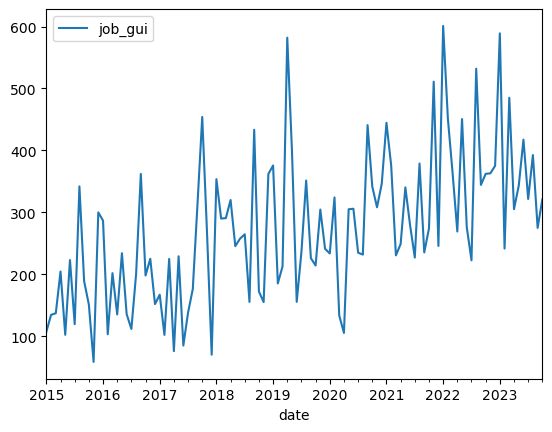

In [11]:
benchmark_term = "government"
geo_iso2 = "PG"
start_time = "2015-01"

benchmark_df = gt.to_df(gt.get_graph(benchmark_term, geo_iso2, start_time))
benchmark_df = benchmark_df.drop("term", axis=1).rename({"value": "benchmark"},
                                                        axis=1)

local_trends_df = pd.DataFrame()
for term in job_words:
    r = gt.get_graph(term, geo_iso2, start_time)
    r_df = gt.to_df(r)
    print(
        f"{term} : {(r_df.value==0).sum()} out of {len(r_df)} rows with zero values."
    )
    r_df = (r_df.drop("term", axis=1).rename({"value": term}, axis=1))

    if local_trends_df.empty:
        local_trends_df = r_df
    else:
        local_trends_df = local_trends_df.merge(r_df, how="left", on="date")

local_trends_df.columns = [
    col.lower().replace(" ", "_") for col in local_trends_df.columns
]

df = local_trends_df.merge(benchmark_df).drop("date", axis=1).fillna(0)

# Benchmark keyword volumes
svi_bt = df["benchmark"] / df["benchmark"].max()
svi_bj = df["benchmark"] / df.max(axis=1)

df["weight"] = (svi_bt / svi_bj).fillna(0)
for i in df.index:
    df.iloc[i, :-4] = df.iloc[i, :-4] * df["weight"][i]
    
df["job_gui"] =  df.iloc[:, :-4].sum(axis=1)

df["date"] = r_df["date"].tolist()
gui = df.set_index("date").groupby(pd.Grouper(freq='MS'))[["job_gui"]].sum().reset_index()
gui.plot(x="date");

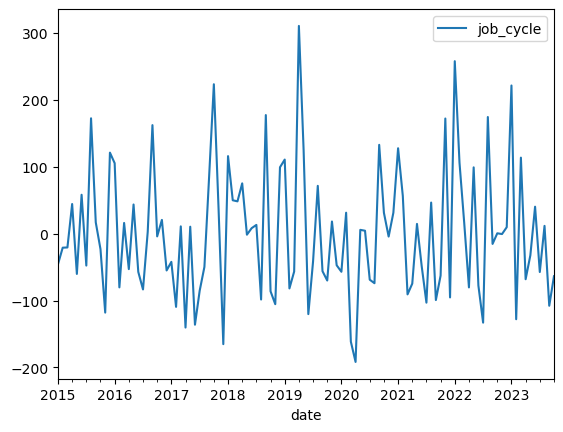

In [12]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(gui["job_gui"], 129600)
gui["job_cycle"] = cycle
gui.plot(x="date", y="job_cycle");
gui.to_csv(target_dir + "png_job_gui.csv", encoding="utf-8")

## Sentiment Analysis

In [13]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from tqdm import tqdm

In [14]:
sid = SentimentIntensityAnalyzer()

news_df = pd.DataFrame()
for name, file in zip(["pc", "abc_au", "rnz"], filepaths):
    df = pd.read_csv(file).drop("Unnamed: 0", axis=1)
    df["date"] = pd.to_datetime(df["date"], utc=False)
    score_df = pd.DataFrame()
    with tqdm(total=len(df)) as pbar:
        for news in df.news:
            news = str(news)
            scores = sid.polarity_scores(news)
            ss_temp = pd.DataFrame(scores, columns=scores.keys(), index=[0])
            if score_df.empty:
                score_df = ss_temp
            else:
                score_df = pd.concat([score_df, ss_temp], axis=0)
            pbar.update(1)
    df["score"] = score_df["compound"].tolist()
    df_sent = (df.set_index("date").groupby(pd.Grouper(freq="MS"))[["score"]].mean().reset_index()
                 .rename({"score": name}, axis=1))
    df_sent["date"] = [pd.to_datetime(d.date()) for d in df_sent.date]
    if news_df.empty:
        news_df = df_sent
    else:
        news_df = news_df.merge(df_sent, how="outer", on="date")

100%|██████████████████████████████████████████████████████████████████████████| 5627/5627 [00:09<00:00, 613.14it/s]


Text(0.5, 1.0, 'Monthly Sentiment Scores in Papua New Guinea')

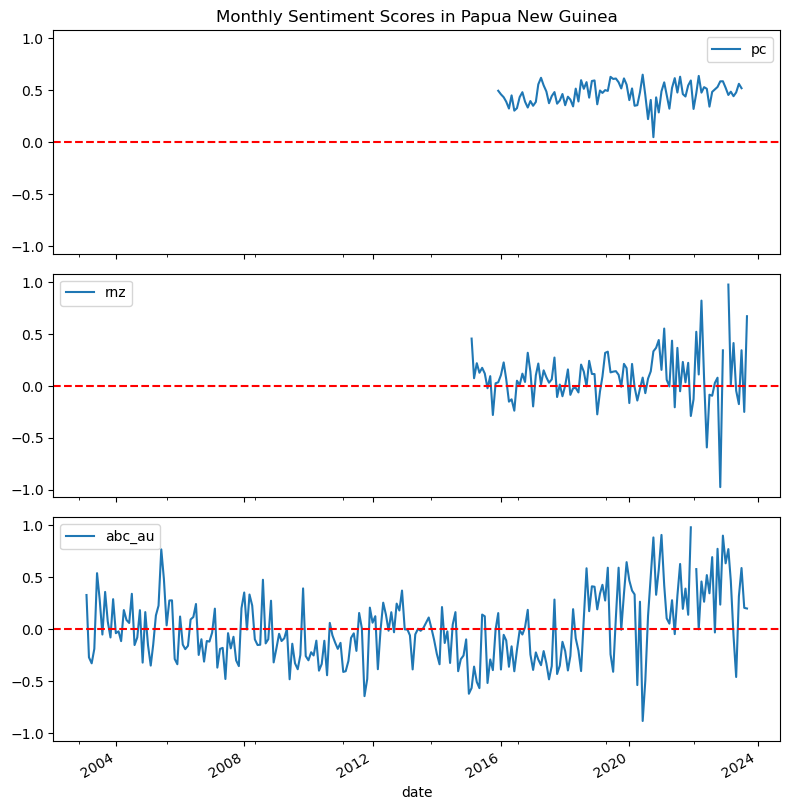

In [15]:
fig, ax = plt.subplots(3,1,figsize=(8, 8), sharex=True, sharey=True)
for idx, col in enumerate(["pc", "rnz", "abc_au"]):
    news_df.plot(x="date", y=col, label=col, ax=ax[idx])
    ax[idx].axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
ax[0].set_title("Monthly Sentiment Scores in Papua New Guinea")

In [16]:
news_df = news_df.sort_values(by="date").reset_index(drop=True).rename({"pc": "post_courier"}, axis=1)
news_df.to_csv(target_dir+"png_sentiment_score_monthly.csv", encoding="utf-8")

## Topic Modeling

In [21]:
from src.text.lda import *
import spacy
from nltk.corpus import stopwords

In [22]:
en = spacy.load('en_core_web_sm')
spacy_stopwords = list(en.Defaults.stop_words)

nltk_stopwords = stopwords.words("english")
nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
spacy_stopwords.extend(nltk_unique)

In [24]:
tm_df = pd.read_csv(filepaths[0]).drop("Unnamed: 0", axis=1)
data = tm_df.news.values.tolist()
data_words = list(sent_to_words(data))

In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [26]:
id2word = corpora.Dictionary(texts_preprocessed)
texts = texts_preprocessed
corpus = [id2word.doc2bow(text) for text in texts]

In [27]:
from gensim.models.wrappers import LdaMallet
mallet_path = os.getcwd() + '/../mallet-2.0.8/bin/mallet'
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=texts_preprocessed,
                                                        mallet_path=mallet_path,
                                                        start=2,
                                                        limit=20,
                                                        step=1)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 1110
total tokens: 1451308
<10> LL/token: -8.42961
<20> LL/token: -8.29317
<30> LL/token: -8.0923
<40> LL/token: -8.00765

0	25	government year school country student people work support service community project program district development health woman provide include education road 
1	25	people police election issue leader time member officer public law provincial week day court report province yesterday national year family 

<50> LL/token: -7.96816
<60> LL/token: -7.94829
<70> LL/token: -7.93565
<80> LL/token: -7.92692
<90> LL/token: -7.92072

0	25	government year school country work student support service community project program people district development health woman include provide child education 
1	25	people police election issue time leader public member officer provincial law day court report yesterday family week national province order 

<100> LL/token: -7.91823
<110> LL/token: -7.91413
<120> LL

<960> LL/token: -7.89332
<970> LL/token: -7.89315
<980> LL/token: -7.89262
<990> LL/token: -7.8935

0	25	government year school country work student support service community project program district development health people include provide woman child provincial 
1	25	people police election issue leader time public officer member day law court report family yesterday provincial week province order man 

<1000> LL/token: -7.89297

Total time: 39 seconds
Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 1110
total tokens: 1451308
<10> LL/token: -8.79361
<20> LL/token: -8.55556
<30> LL/token: -8.28425
<40> LL/token: -8.16106

0	16.66667	people police election leader issue officer provincial member province public report law yesterday order candidate time land man call pay 
1	16.66667	year student school woman child country time family day teacher life give good hospital case event week young hold attend 
2	16.66667	government support service project program work

<660> LL/token: -7.96706
<670> LL/token: -7.96623
<680> LL/token: -7.96533
<690> LL/token: -7.96732

0	16.66667	police people election issue leader officer public law court report member yesterday order case candidate process time office national call 
1	16.66667	year school student woman child education community country time family program work training live people good life teacher day give 
2	16.66667	government people service project district work provincial development health province support country area include road provide fund year plan build 

<700> LL/token: -7.96689
<710> LL/token: -7.96657
<720> LL/token: -7.96705
<730> LL/token: -7.96668
<740> LL/token: -7.9677

0	16.66667	police people election issue leader officer public law court report member yesterday order case candidate process time office call national 
1	16.66667	year school student woman child education community country time program family training people work live good life teacher day give 
2	16.66667	govern

<310> LL/token: -8.02467
<320> LL/token: -8.02559
<330> LL/token: -8.02421
<340> LL/token: -8.02209

0	12.5	year school student woman education child program country training community teacher work good support give church high time life event 
1	12.5	government service people project district provincial work development country support health province provide fund include year road plan policy area 
2	12.5	police people village officer man area family hospital market team operation city time vehicle live water day home report station 
3	12.5	election people issue leader member law court national candidate process land state public order office time pay yesterday provincial act 

<350> LL/token: -8.02164
<360> LL/token: -8.02057
<370> LL/token: -8.02093
<380> LL/token: -8.02182
<390> LL/token: -8.02112

0	12.5	school year student woman education child program training country community teacher good work support time give church high event life 
1	12.5	government service people project 

<910> LL/token: -8.02212
<920> LL/token: -8.02279
<930> LL/token: -8.02277
<940> LL/token: -8.02158

0	12.5	school year student woman education child country program training community work teacher support good give church high time event change 
1	12.5	government service people project district work development provincial country support health province provide fund year road include plan area program 
2	12.5	police people village officer man family hospital team area operation city market time vehicle live day water report home station 
3	12.5	people election issue leader member law national court public candidate order process state government office time provincial pay land yesterday 

<950> LL/token: -8.0225
<960> LL/token: -8.02233
<970> LL/token: -8.02139
<980> LL/token: -8.02283
<990> LL/token: -8.02175

0	12.5	school year student woman education child country program community training work teacher support good give high church time event life 
1	12.5	government service people

<410> LL/token: -8.06685
<420> LL/token: -8.0669
<430> LL/token: -8.06561
<440> LL/token: -8.06482

0	10	government country development leader people support include policy national plan member address work issue important leadership develop opportunity partner landowner 
1	10	school year student provincial program service district government province education project fund training support high receive teacher health work provide 
2	10	woman people year child family time community day life health hospital live church good event young team give medical care 
3	10	people area road local work village community land company market city water money place affect business youth start vehicle travel 
4	10	police election officer issue law court report order candidate case leader yesterday process public office conduct member vote act national 

<450> LL/token: -8.06684
<460> LL/token: -8.06598
<470> LL/token: -8.06705
<480> LL/token: -8.06684
<490> LL/token: -8.06695

0	10	government country 

<910> LL/token: -8.06394
<920> LL/token: -8.06303
<930> LL/token: -8.06445
<940> LL/token: -8.06335

0	10	government country development include national leader support policy plan people project issue provide work important address leadership sector develop system 
1	10	school year student provincial service program district province government education project fund support training health receive teacher high work provide 
2	10	people woman year child community family time life day hospital church live good event health young team youth bring work 
3	10	people area road local work village land company market community city place water money business affect vehicle start time travel 
4	10	police election officer issue law court report order candidate case leader yesterday process public member conduct office national vote act 

<950> LL/token: -8.06404
<960> LL/token: -8.06439
<970> LL/token: -8.06503
<980> LL/token: -8.06534
<990> LL/token: -8.06437

0	10	government country developm


0	8.33333	school year student provincial district program work education province training service fund government teacher project build receive high support complete 
1	8.33333	government country development project plan support policy national include business sector provide system develop benefit improve address partner economic resource 
2	8.33333	woman child year country community support church time day life work event good change young family visit group today give 
3	8.33333	health service team company hospital water include provide accord operation medical month public facility affect care travel patient cost authority 
4	8.33333	people leader village province area land road market community city live place call man vehicle time money home work family 
5	8.33333	police election officer issue law court candidate order process report national member case public office yesterday act party conduct vote 

<350> LL/token: -8.08361
<360> LL/token: -8.08357
<370> LL/token: -8.08268
<

<710> LL/token: -8.08258
<720> LL/token: -8.08067
<730> LL/token: -8.07925
<740> LL/token: -8.08167

0	8.33333	school year student provincial district program education province government work fund training teacher service build receive support high complete project 
1	8.33333	government country development project plan support policy include national business sector system provide improve develop benefit partner address economic resource 
2	8.33333	woman year child country community work support time church life change good day event family young today visit world hold 
3	8.33333	health service team hospital provide water include operation accord medical week care facility affect month company public area patient food 
4	8.33333	people road leader village province area land market city community live time work man vehicle money call place home local 
5	8.33333	police election officer issue law court order candidate report process national public member case yesterday office act party

<110> LL/token: -8.16067
<120> LL/token: -8.1531
<130> LL/token: -8.14736
<140> LL/token: -8.1434

0	7.14286	police officer man report vehicle order station law charge case people yesterday operation call security fight province peace week accord 
1	7.14286	government country development support plan policy national include sector service leadership leader address partner important economic develop provide budget level 
2	7.14286	woman people child year community life health family time hospital live church work support event day visit young good medical 
3	7.14286	election issue court leader candidate member process national people law state decision party office vote public time official parliament conduct 
4	7.14286	city public time awareness place company team business include travel water food day authority increase affect sell covid accord problem 
5	7.14286	people project district provincial service province area road work government fund local community land build market villag

<460> LL/token: -8.10162
<470> LL/token: -8.10104
<480> LL/token: -8.10061
<490> LL/token: -8.10342

0	7.14286	police officer report man vehicle order station case charge law yesterday security operation issue call fight home arrest force death 
1	7.14286	government country development support policy plan include national business sector provide partner address important develop improve system level economic ensure 
2	7.14286	people woman year community family time life child live work church event good day young change country visit world youth 
3	7.14286	election leader court issue national member candidate process law state decision people party vote public office parliament official governor time 
4	7.14286	health market hospital team city water medical public affect awareness include patient sell time food care day area place authority 
5	7.14286	people government provincial project service province district work road fund area community local land year build village funding deliv

<810> LL/token: -8.09747
<820> LL/token: -8.09782
<830> LL/token: -8.09913
<840> LL/token: -8.09934

0	7.14286	police officer report man vehicle order station case law charge issue yesterday operation security call accord arrest involve force situation 
1	7.14286	country government development policy plan support business include sector provide important partner national develop system address level economic improve partnership 
2	7.14286	people woman year community family life time live leader church good event work day young change member country youth child 
3	7.14286	election issue court member national leader candidate process state law decision party vote public office parliament official time pay polling 
4	7.14286	health market hospital team water city medical affect care awareness patient area sell food time include public day authority provide 
5	7.14286	people government provincial project service province district work road fund area year community land local build support 

<160> LL/token: -8.12829
<170> LL/token: -8.12429
<180> LL/token: -8.12328
<190> LL/token: -8.11932

0	6.25	election leader issue national candidate process member public decision party people vote time parliament law polling conduct state office official 
1	6.25	development community policy support country plan sector increase improve provide program business develop address system awareness partner partnership include economic 
2	6.25	police officer report case order court law man issue charge station yesterday peace act arrest security force deal involve fight 
3	6.25	people woman year time family community live child life work good day church change youth young thing give serve bring 
4	6.25	country support visit event leader include member group hold meeting continue important opportunity papua work present host meet local share 
5	6.25	health area hospital market service city vehicle village water public team facility medical affect town patient sell authority travel care 
6	6.25

<510> LL/token: -8.10604
<520> LL/token: -8.10579
<530> LL/token: -8.10854
<540> LL/token: -8.10558

0	6.25	election issue national candidate process leader public member court decision party vote state parliament time people law polling conduct office 
1	6.25	country development policy plan business support provide community sector improve increase system develop address level economic partner partnership government program 
2	6.25	police officer report case order law issue vehicle man station charge court yesterday security operation arrest act force province accord 
3	6.25	people woman community time family year live life child work church good day change youth young village leader thing serve 
4	6.25	country support visit event include year work group member hold leader papua important meeting continue host present opportunity world meet 
5	6.25	health hospital area market city service water team facility public affect medical town patient sell authority travel awareness provide ca

<860> LL/token: -8.11077
<870> LL/token: -8.11043
<880> LL/token: -8.11201
<890> LL/token: -8.11334

0	6.25	election issue national candidate process leader court member decision state party public law vote parliament time office polling official conduct 
1	6.25	country development government policy business plan support sector improve provide increase system develop address level partner economic partnership include program 
2	6.25	police officer report order vehicle case issue law station man charge security yesterday operation arrest force act involve suspect accord 
3	6.25	people woman community family time live year child life work good church leader change village youth young day thing serve 
4	6.25	country support visit event year include group hold member work world important present meeting continue host papua share local opportunity 
5	6.25	health area hospital market city service water team affect facility medical public awareness provide patient sell care travel covid suppl

<160> LL/token: -8.16409
<170> LL/token: -8.16147
<180> LL/token: -8.15954
<190> LL/token: -8.15875

0	5.55556	police officer report man order station law issue charge vehicle security case arrest yesterday force operation involve suspect fight act 
1	5.55556	election court leader national candidate process member issue decision law party vote public office parliament people political state order general 
2	5.55556	woman people community family life year church leader event work live time change young good youth day group child member 
3	5.55556	market area village city water people place travel public town home road food time sell affect local live main leave 
4	5.55556	government people provincial project district province service work fund road support community development area build funding program deliver local infrastructure 
5	5.55556	government year business land company pay money country give landowner state benefit issue cent time good cost add power increase 
6	5.55556	coun

<460> LL/token: -8.14797
<470> LL/token: -8.14793
<480> LL/token: -8.14962
<490> LL/token: -8.14784

0	5.55556	police officer report man order law station charge vehicle case issue security operation yesterday involve arrest force suspect situation accord 
1	5.55556	election court leader candidate national member process decision issue party people vote law parliament official public time polling office political 
2	5.55556	woman people family year life community church event time leader live day young good change youth work country member group 
3	5.55556	market area village city people water place time travel road town sell public food home local day affect main start 
4	5.55556	people government provincial project district province work service fund road development build community support area funding deliver infrastructure year local 
5	5.55556	government business year land company pay money issue state give landowner benefit country power cent cost sign budget department agreemen

<760> LL/token: -8.14989
<770> LL/token: -8.15088
<780> LL/token: -8.15109
<790> LL/token: -8.14987

0	5.55556	police officer report man order law vehicle station charge security case issue operation yesterday arrest involve force situation suspect fight 
1	5.55556	election court leader candidate national member process party vote people law parliament official decision issue polling time public office political 
2	5.55556	woman people year family church life time community event live day good young work change leader youth country bring today 
3	5.55556	market area village city water people local travel town start sell place food day main public home affect live fire 
4	5.55556	people government provincial province project district work service road fund build support community area development funding deliver infrastructure program year 
5	5.55556	government business year issue land pay company money state landowner give benefit budget department current power cent sign agreement cos

<60> LL/token: -8.27969
<70> LL/token: -8.24507
<80> LL/token: -8.21868
<90> LL/token: -8.20216

0	5	school student year education training program teacher high child parent week learn attend institution primary study receive train skill grade 
1	5	country policy development develop opportunity system important plan work business support challenge provide improve economy level economic international include sector 
2	5	government issue land state company pay landowner national public give include process sign department address medium decision year agreement interest 
3	5	government project district provincial service support fund community province development program year funding build infrastructure local plan deliver rural area 
4	5	health service hospital team provide support child medical awareness facility care staff country patient include community centre covid worker accord 
5	5	woman family year life day event community church young time youth live group man bring culture to

<340> LL/token: -8.14309

0	5	school student year education program training teacher high child parent learn week institution skill primary attend study train grade receive 
1	5	country policy development system important develop support plan include improve opportunity sector economic challenge level economy work partner international provide 
2	5	government issue land state pay public landowner process company decision national medium department give sign agreement act office include report 
3	5	government provincial project district province service fund support development community year program people funding build work infrastructure plan deliver rural 
4	5	health service hospital child community provide team support facility medical awareness care staff country patient centre include covid worker case 
5	5	woman year family life church event community day young time group live man culture hold bring today late girl good 
6	5	people work road market good place city time business 

<610> LL/token: -8.14425
<620> LL/token: -8.14367
<630> LL/token: -8.14104
<640> LL/token: -8.14209

0	5	school student year education program training teacher high child parent week learn institution skill primary study attend train grade fee 
1	5	country policy development support plan important include develop system improve sector provide opportunity economic challenge business economy partner level work 
2	5	government issue land state pay public landowner process decision national company department medium give office sign act report agreement current 
3	5	government provincial project district province service fund support year development people work community program build funding infrastructure deliver rural area 
4	5	health service hospital community child team provide medical facility awareness support care staff patient include centre covid worker country case 
5	5	woman year family life church event community day young time group live culture man today give good hold late

<910> LL/token: -8.14257
<920> LL/token: -8.14307
<930> LL/token: -8.14362
<940> LL/token: -8.14341

0	5	school student year education program training teacher high child parent learn week institution skill primary study train attend grade fee 
1	5	country development policy plan important develop support system sector provide include economic improve partner opportunity business work economy level challenge 
2	5	government issue land state pay public landowner process decision office act company give department national agreement sign report medium current 
3	5	government provincial project district province service fund support year people community work development program build funding infrastructure deliver rural area 
4	5	health hospital child service team provide community support medical awareness care facility staff patient include centre covid worker country accord 
5	5	woman year family church life event community young day time group live culture man good today hold great b

<160> LL/token: -8.17353
<170> LL/token: -8.16988
<180> LL/token: -8.16531
<190> LL/token: -8.16498

0	4.54545	health hospital service team facility medical care staff child patient provide centre accord covid worker case month include treatment equipment 
1	4.54545	year family time day life live young thing late good child culture leave home man long mother today feel lose 
2	4.54545	country business market policy development economic sector increase develop economy industry agriculture plan investment local world improve international sell opportunity 
3	4.54545	people leader member work country church visit support year event hold serve good group present continue open host meeting give 
4	4.54545	government provincial project district province fund service year development national funding plan landowner budget infrastructure department benefit deliver receive money 
5	4.54545	election candidate national process party vote official polling leader parliament people general electorat

<410> LL/token: -8.14097
<420> LL/token: -8.14076
<430> LL/token: -8.14174
<440> LL/token: -8.14109

0	4.54545	health service hospital team facility medical care provide staff patient child centre covid worker country include accord case month treatment 
1	4.54545	family year time day life live young child late culture leave event mother thing man home lose today woman feel 
2	4.54545	country business policy economic development increase economy company develop market local industry include agriculture sector investment international world grow produce 
3	4.54545	people leader member country work good church visit support serve continue year hold group bring present meeting host leadership lead 
4	4.54545	government provincial district project province service fund year development national funding plan infrastructure deliver budget receive benefit money department support 
5	4.54545	election candidate process national party vote official parliament time polling electorate general poli

<660> LL/token: -8.14279
<670> LL/token: -8.14432
<680> LL/token: -8.14313
<690> LL/token: -8.14336

0	4.54545	health hospital service team facility medical care provide staff patient child centre covid include worker accord case treatment month receive 
1	4.54545	year family day life time event young live child woman late culture leave home mother thing man today lose long 
2	4.54545	country business policy economic increase economy local company industry include develop development agriculture investment grow world produce small international farmer 
3	4.54545	people leader member country work good church visit serve leadership community change bring year continue group meeting urge time support 
4	4.54545	government provincial project district province service fund year development national funding plan infrastructure deliver support budget rural work receive benefit 
5	4.54545	election candidate national party process vote official parliament court polling time electorate general c

<910> LL/token: -8.14581
<920> LL/token: -8.14789
<930> LL/token: -8.14498
<940> LL/token: -8.14715

0	4.54545	health hospital service team facility medical care staff child provide patient centre covid worker case country include treatment equipment week 
1	4.54545	year family day time life event young live late child culture woman leave mother home man thing long feel celebrate 
2	4.54545	country business increase economic local policy economy industry company develop include development agriculture grow investment region cent world produce small 
3	4.54545	people leader member country work good church visit serve change community leadership continue bring urge time group year meeting governor 
4	4.54545	government provincial project district province service fund year development national plan funding support infrastructure deliver work rural budget receive include 
5	4.54545	election candidate national court party vote process official parliament polling time political general elec

<160> LL/token: -8.1808
<170> LL/token: -8.1774
<180> LL/token: -8.17488
<190> LL/token: -8.17425

0	4.16667	people area village city problem water place public affect community issue town call live authority main proper goroka continue lot 
1	4.16667	court law issue state case order office charge act decision process pay matter report claim public land lawyer rule national 
2	4.16667	training system work management include information base meeting provide public meet important train department hold agency skill organisation conduct ensure 
3	4.16667	government provincial district project road province fund work people service year build funding landowner land infrastructure benefit complete money building 
4	4.16667	woman people community country leader change church work good youth member nation support life world event peace leadership young group 
5	4.16667	health service hospital team facility medical support care provide centre patient staff child covid include worker awareness c

<410> LL/token: -8.15824
<420> LL/token: -8.15984
<430> LL/token: -8.15684
<440> LL/token: -8.15856

0	4.16667	people area village city water place problem public affect community issue town authority main proper live call concern power clean 
1	4.16667	court issue law state order case office land decision pay act public process matter claim report national rule lawyer legal 
2	4.16667	training system program work management include information meeting provide base important train meet public department agency skill conduct hold organisation 
3	4.16667	government provincial project district province road work fund service people year build funding landowner infrastructure benefit deliver money complete development 
4	4.16667	woman people community work church change leader country support youth good member life group young world live event leadership nation 
5	4.16667	health service hospital facility team provide medical support care centre patient include covid worker case staff child

<660> LL/token: -8.15679
<670> LL/token: -8.15553
<680> LL/token: -8.15791
<690> LL/token: -8.1571

0	4.16667	people area village city problem water place public affect issue town community authority proper main live concern time call clean 
1	4.16667	court issue law state order land case pay decision public act process office landowner matter claim national report rule lawyer 
2	4.16667	program training system work management provide information include base train meeting important meet public conduct skill ensure agency department participant 
3	4.16667	government provincial project district province service road fund people work year funding build infrastructure development deliver area rural complete building 
4	4.16667	people woman community change church work leader support youth country good member life group young live leadership bring event lead 
5	4.16667	health service hospital support facility team provide medical care patient centre include case child covid worker staff tr

<910> LL/token: -8.15973
<920> LL/token: -8.15869
<930> LL/token: -8.1582
<940> LL/token: -8.15854

0	4.16667	people area village city place water problem affect public town issue community live authority main concern proper clean call time 
1	4.16667	court issue law state land pay order landowner decision process case office act public matter claim national report rule lawyer 
2	4.16667	program training system work provide management include information base train public meeting important service skill conduct ensure department meet agency 
3	4.16667	government provincial project district province road people service fund work year funding build development infrastructure rural deliver complete receive building 
4	4.16667	woman community people change church leader work support youth country member good life group young event live leadership bring peace 
5	4.16667	health hospital service support team facility medical care provide patient child centre include covid worker case country 

<110> LL/token: -8.22789
<120> LL/token: -8.21865
<130> LL/token: -8.21129
<140> LL/token: -8.20334

0	3.84615	health service hospital facility medical care child staff patient centre provide team worker treatment accord case time equipment doctor fire 
1	3.84615	district project development road service plan government infrastructure work rural sector build fund area funding province program deliver improve local 
2	3.84615	program training provide important support opportunity country partner train base skill level information role australian develop challenge partnership include improve 
3	3.84615	court issue law public office order act process system decision case state report national matter rule lawyer legal department follow 
4	3.84615	police officer vehicle report man station charge arrest security force suspect operation order law investigation yesterday situation victim involve incident 
5	3.84615	woman family life live day year time young child late culture man today girl mo

<310> LL/token: -8.17625
<320> LL/token: -8.175
<330> LL/token: -8.1749
<340> LL/token: -8.17382

0	3.84615	health service hospital facility medical child care patient provide team staff centre worker case treatment country accord year equipment number 
1	3.84615	provincial district project government road service province development fund work infrastructure build funding people rural plan area program deliver year 
2	3.84615	program training provide opportunity plan develop important improve country system partner base support include partnership management information level international australian 
3	3.84615	court law issue public order office case act decision state process system report matter national rule question lawyer follow legal 
4	3.84615	police officer vehicle man report station charge arrest suspect force security order fire operation investigation law situation involve victim incident 
5	3.84615	woman family life year day young time live culture child man late today mo

<510> LL/token: -8.16438
<520> LL/token: -8.16463
<530> LL/token: -8.1676
<540> LL/token: -8.16351

0	3.84615	health service hospital medical facility care child patient team provide staff covid worker centre country case treatment awareness equipment include 
1	3.84615	provincial district project government service province road work fund development funding build infrastructure people area deliver rural year plan program 
2	3.84615	development country policy training plan important program develop improve opportunity provide include partner sector system level partnership base key international 
3	3.84615	court law issue office public order case act state decision process report matter question medium system national rule lawyer legal 
4	3.84615	police officer vehicle man report station charge arrest force suspect operation order fire security investigation law yesterday victim situation involve 
5	3.84615	woman family year life time day young live child culture late man mother girl 

<710> LL/token: -8.15583
<720> LL/token: -8.15717
<730> LL/token: -8.15615
<740> LL/token: -8.15799

0	3.84615	health hospital service medical child care facility patient team provide staff covid centre worker country case treatment awareness include emergency 
1	3.84615	provincial district government project service province road work fund development build funding infrastructure year people deliver rural area program plan 
2	3.84615	country development policy plan develop opportunity improve sector system important include provide level partnership partner key international focus economic address 
3	3.84615	court law issue order public office case act process report decision state matter question national system medium rule follow lawyer 
4	3.84615	police officer vehicle man report station arrest operation charge force suspect fire security order investigation involve situation victim incident yesterday 
5	3.84615	woman family year life day young time child live culture man late even

<910> LL/token: -8.15425
<920> LL/token: -8.1526
<930> LL/token: -8.15017
<940> LL/token: -8.15228

0	3.84615	health hospital service medical child care team facility staff patient provide covid case worker centre treatment country equipment emergency awareness 
1	3.84615	provincial district government project service province road work fund development build funding infrastructure year people deliver rural area program plan 
2	3.84615	country development policy plan develop improve sector opportunity important system include economic provide key level international challenge focus economy create 
3	3.84615	court law issue office public order case act report process decision state medium matter question system rule lawyer national follow 
4	3.84615	police officer vehicle man station report arrest operation charge force suspect order fire security investigation law yesterday victim incident situation 
5	3.84615	woman family year life day young time child live culture man mother late eve

<110> LL/token: -8.22854
<120> LL/token: -8.2201
<130> LL/token: -8.21229
<140> LL/token: -8.20352

0	3.57143	police officer man report vehicle station arrest death force suspect fire operation investigation fight situation victim incident crime kill unit 
1	3.57143	government provincial district project province people fund service development support year funding program plan infrastructure deliver national rural budget governor 
2	3.57143	people village area market city water community live place affect sell food town public goroka problem local clean resident money 
3	3.57143	government land pay company issue landowner state sign give agreement benefit year money payment cent interest current call release agree 
4	3.57143	include country visit week meeting team awareness report information meet issue conduct medium important hold security host region effort yesterday 
5	3.57143	woman community people church youth event young live support group change life day culture girl celebrate

<310> LL/token: -8.17783
<320> LL/token: -8.17904
<330> LL/token: -8.17765
<340> LL/token: -8.17823

0	3.57143	police officer man report vehicle station arrest suspect operation force fire situation investigation fight victim incident charge unit death security 
1	3.57143	government provincial district project province people service fund support development year program funding deliver infrastructure rural national plan community area 
2	3.57143	people market village area city water affect community place sell food town live goroka public local clean problem resident disaster 
3	3.57143	government land pay company issue landowner state year give money sign agreement benefit payment call cent interest current release account 
4	3.57143	country include visit meeting week team information meet issue hold important medium conduct region awareness security host continue report australian 
5	3.57143	woman community church people event youth support young group change culture day girl live c

<510> LL/token: -8.17575
<520> LL/token: -8.17695
<530> LL/token: -8.17613
<540> LL/token: -8.17866

0	3.57143	police officer man report vehicle station arrest force suspect fire operation investigation fight situation victim charge incident unit security crime 
1	3.57143	government provincial district project province people service fund support development year funding program deliver rural infrastructure area community receive national 
2	3.57143	people market area village city water affect sell town place community food goroka live public clean resident local money disaster 
3	3.57143	government land pay company issue landowner state year give sign money agreement benefit payment cent call current release interest account 
4	3.57143	country include visit meeting information week team member meet hold medium important region papua host leader experience australian security awareness 
5	3.57143	woman community church event youth support young change group culture day people girl play

<710> LL/token: -8.177
<720> LL/token: -8.17703
<730> LL/token: -8.17599
<740> LL/token: -8.17669

0	3.57143	police officer report man vehicle station arrest force suspect operation fire investigation fight security situation charge victim unit incident yesterday 
1	3.57143	government provincial district people province project service fund support development year funding program deliver rural area infrastructure community governor receive 
2	3.57143	people market area village city water community sell place affect food town goroka public live clean resident local disaster buy 
3	3.57143	government land pay company issue landowner year state give sign money agreement benefit payment cent call interest release current claim 
4	3.57143	country visit include meeting hold week information meet member team important medium region australian leader host security papua provide present 
5	3.57143	woman community church event support youth young group culture year change day promote girl celeb

<910> LL/token: -8.1758
<920> LL/token: -8.17512
<930> LL/token: -8.17595
<940> LL/token: -8.17739

0	3.57143	police officer report man vehicle station arrest suspect operation fire force order security charge investigation involve law victim fight incident 
1	3.57143	government provincial people district province project service fund support development year funding program deliver rural community area infrastructure governor receive 
2	3.57143	people area market city village water town place sell community food affect goroka clean live public local resident proper disaster 
3	3.57143	government land pay company issue landowner year state give money sign agreement benefit payment cent current call receive interest include 
4	3.57143	country include visit member meeting week information meet hold important region leader medium team australian host papua security present continue 
5	3.57143	woman community church event youth support young group change day culture year program promote ce

<110> LL/token: -8.2287
<120> LL/token: -8.21873
<130> LL/token: -8.21395
<140> LL/token: -8.20981

0	3.33333	country development policy plan government sector develop economic economy increase improve key resource level investment partner cent capacity challenge include 
1	3.33333	community program woman support training youth work local provide train skill business activity organisation farmer partnership awareness assist area launch 
2	3.33333	provincial work province officer office public issue service order operation ensure act situation address fire continue management staff week duty 
3	3.33333	police court case officer report charge man law order arrest station suspect investigation lawyer victim incident matter crime kill involve 
4	3.33333	health hospital service medical facility team care patient provide covid worker centre include treatment equipment staff case emergency doctor support 
5	3.33333	area land company water landowner pay affect city issue proper clean payment g

<310> LL/token: -8.17064
<320> LL/token: -8.17028
<330> LL/token: -8.17278
<340> LL/token: -8.17164

0	3.33333	country development policy plan government sector develop economic economy increase key improve resource cent level investment include partner implement region 
1	3.33333	community program woman support training youth provide local train skill work activity awareness business area farmer partnership organisation launch initiative 
2	3.33333	provincial province work officer service office operation ensure management serve staff public security act order issue continue week authority administrator 
3	3.33333	police court order case law officer report charge man station arrest suspect investigation lawyer victim involve incident crime kill unit 
4	3.33333	health hospital medical team service facility care patient provide covid worker centre case treatment equipment support accord emergency doctor include 
5	3.33333	land area company water pay landowner issue affect give proper st

<510> LL/token: -8.17144
<520> LL/token: -8.17304
<530> LL/token: -8.17247
<540> LL/token: -8.1701

0	3.33333	country development policy government plan sector develop economic economy increase improve key level include resource partner region investment focus capacity 
1	3.33333	community woman program support training youth local business train provide skill activity organisation awareness group farmer participant work partnership initiative 
2	3.33333	provincial province work officer service office ensure operation management staff serve act security week public department continue administrator senior meeting 
3	3.33333	police court order case officer law report charge man station arrest suspect investigation lawyer incident crime involve matter justice unit 
4	3.33333	health hospital service medical facility provide patient team care covid worker centre treatment case equipment emergency include doctor cancer support 
5	3.33333	land company pay issue water area landowner affect st

<710> LL/token: -8.16799
<720> LL/token: -8.1683
<730> LL/token: -8.16829
<740> LL/token: -8.16733

0	3.33333	country development policy plan government sector develop economic economy increase key improve level include resource partner investment region partnership important 
1	3.33333	community woman program support training youth local skill train business provide activity awareness organisation farmer participant group work assist base 
2	3.33333	provincial province work officer service office operation ensure management week department staff security act team public serve central administrator continue 
3	3.33333	police court order case officer law report charge man station arrest suspect investigation incident involve crime yesterday vehicle unit accord 
4	3.33333	health hospital medical service facility care provide patient child team covid worker centre treatment case equipment emergency accord doctor cancer 
5	3.33333	land company pay water issue landowner area affect state gi

<910> LL/token: -8.1705
<920> LL/token: -8.17009
<930> LL/token: -8.17086
<940> LL/token: -8.17238

0	3.33333	country development policy government plan sector develop economic economy increase improve include key level resource partner region implement investment capacity 
1	3.33333	community woman program support training youth local business train skill provide awareness activity organisation farmer participant group partnership initiative assist 
2	3.33333	provincial province work service officer office ensure management operation department staff public week year act serve team continue meeting senior 
3	3.33333	police court officer order case report law man charge station arrest suspect investigation yesterday incident involve crime unit vehicle force 
4	3.33333	health hospital service medical child facility care patient provide team covid worker case centre treatment emergency equipment include doctor support 
5	3.33333	land company pay issue water landowner government affect ar

<110> LL/token: -8.21797
<120> LL/token: -8.20938
<130> LL/token: -8.19982
<140> LL/token: -8.19366

0	3.125	government provincial project district province fund development people year funding service national infrastructure plan governor receive budget administration rural deliver 
1	3.125	business country increase local economic economy industry agriculture grow investment sector farmer produce tourism trade develop opportunity product potential coffee 
2	3.125	road work build area market cost open complete building local transport construction company main access site major power maintain include 
3	3.125	people village city water community area youth live good town sell money place fire lot problem clean thing resident buy 
4	3.125	school student education year teacher high learn parent primary study institution grade fee secondary child attend teach graduate program university 
5	3.125	woman church event group young culture work people change celebrate promote good member country

<310> LL/token: -8.15635
<320> LL/token: -8.15759
<330> LL/token: -8.1562
<340> LL/token: -8.15395

0	3.125	government provincial district province project people fund service development year funding rural deliver national governor infrastructure budget receive plan member 
1	3.125	business market local country increase economic economy project industry agriculture investment grow produce sector farmer tourism trade small food product 
2	3.125	road work build area cost building complete open transport local construction market access service power infrastructure site include major facility 
3	3.125	people village community area city water youth live town sell place money good fire clean affect lot resident change buy 
4	3.125	school student education year teacher high parent primary study institution grade learn fee child secondary teach graduate attend university book 
5	3.125	woman church event country group young culture people promote hold member host world celebrate change good v

<510> LL/token: -8.15193
<520> LL/token: -8.15214
<530> LL/token: -8.15284
<540> LL/token: -8.15283

0	3.125	government provincial district province project people fund service development year funding rural national deliver governor budget infrastructure receive member administration 
1	3.125	business country local increase economic economy project industry agriculture sector grow produce farmer tourism small investment product potential coffee trade 
2	3.125	road work build area cost complete building open transport access construction local service infrastructure house site power major travel maintain 
3	3.125	people village area community city market water youth live place town sell affect money clean fire resident main proper good 
4	3.125	school student education year teacher high parent primary study institution grade learn child secondary fee attend teach graduate university book 
5	3.125	woman church event country group culture young change promote member host celebrate people

<710> LL/token: -8.15275
<720> LL/token: -8.15247
<730> LL/token: -8.15216
<740> LL/token: -8.15362

0	3.125	government provincial district province people service fund project year development funding rural deliver governor national budget member support receive administration 
1	3.125	business local country increase economic industry project agriculture grow economy produce small farmer tourism product potential coffee market environment develop 
2	3.125	road work build project area cost complete building open service access local transport infrastructure construction power major facility site house 
3	3.125	people village area community city market water youth live town affect sell place money clean fire resident main disaster proper 
4	3.125	school student education year teacher high parent primary study institution grade child fee secondary learn attend teach graduate university book 
5	3.125	woman church event country culture young change host hold group world promote celebrate p

<910> LL/token: -8.1559
<920> LL/token: -8.15287
<930> LL/token: -8.15332
<940> LL/token: -8.15237

0	3.125	government provincial province district people service fund year development funding rural governor national budget project deliver support member receive administration 
1	3.125	business country increase local economic industry agriculture economy grow produce farmer tourism small project product potential coffee market food good 
2	3.125	project road work build area building complete cost infrastructure service open access transport local construction major facility power include house 
3	3.125	people village area city market water community live affect place town money sell fire clean resident main home proper disaster 
4	3.125	school student education year teacher high parent primary study institution grade fee secondary child learn teach graduate attend university book 
5	3.125	woman church event country culture change hold young member year world host promote play group cel

<80> LL/token: -8.29292
<90> LL/token: -8.27399

0	2.94118	village local visit year start goroka week community farmer money give people food area time buy coffee produce province set 
1	2.94118	woman program community training youth skill young train opportunity child participant change girl encourage role book support knowledge violence learn 
2	2.94118	support service provide work staff team operation include management manager continue assist assistance australian company deliver officer operate organisation centre 
3	2.94118	public system report information issue ensure process national medium agency conduct include law place result department set provide important address 
4	2.94118	project district road people work build service area infrastructure rural building complete cost access construction deliver funding major development community 
5	2.94118	people water affect community issue problem area week time live continue raise month face situation yesterday concern close appeal

<210> LL/token: -8.19985
<220> LL/token: -8.19869
<230> LL/token: -8.19502
<240> LL/token: -8.1915

0	2.94118	people village community local visit start money area province food goroka week farmer year bring buy time produce live coffee 
1	2.94118	woman program community training youth change skill train young opportunity participant awareness work girl knowledge learn violence important encourage role 
2	2.94118	support work service provide continue staff team management operation manager assist deliver assistance company receive job organisation give serve present 
3	2.94118	public system report information ensure process medium national include provide agency require issue set conduct important place management number base 
4	2.94118	district project road work service build infrastructure area rural people building complete cost development funding fund deliver access construction program 
5	2.94118	people issue problem water affect address area face time concern continue yesterday 

<360> LL/token: -8.17466
<370> LL/token: -8.17476
<380> LL/token: -8.17268
<390> LL/token: -8.17497

0	2.94118	people village business market local money sell goroka food small good area start produce farmer agriculture community buy live coffee 
1	2.94118	woman community program training youth change train skill awareness young participant work violence role learn encourage activity opportunity society knowledge 
2	2.94118	support work service provide continue staff team assist receive assistance manager management present good operation deliver give job ensure effort 
3	2.94118	system public report information process ensure medium provide national agency include management set conduct require important issue number citizen result 
4	2.94118	project district road build service work people area infrastructure rural building complete cost fund year funding development program access deliver 
5	2.94118	people issue problem water affect address area face concern continue time power lot s

<510> LL/token: -8.16891
<520> LL/token: -8.17129
<530> LL/token: -8.1704
<540> LL/token: -8.16976

0	2.94118	village business market people local money sell food goroka small start good produce farmer agriculture buy grow product area coffee 
1	2.94118	woman community program training youth change train skill awareness young participant work violence role encourage life aim knowledge society opportunity 
2	2.94118	support work service provide continue staff team assist assistance give management receive manager ensure operation good job deliver present effort 
3	2.94118	system public report information ensure medium process national provide include conduct agency important base set management require issue department review 
4	2.94118	project district road build service people work area infrastructure complete building rural development cost fund funding access year local plan 
5	2.94118	people issue problem water affect address area face concern continue power time community happen l

<660> LL/token: -8.1689
<670> LL/token: -8.17052
<680> LL/token: -8.17162
<690> LL/token: -8.1697

0	2.94118	business market local people money sell food good goroka small start produce agriculture farmer buy grow product coffee village plant 
1	2.94118	woman community program training change youth train skill awareness young work participant role violence opportunity aim create group knowledge activity 
2	2.94118	support work service continue provide team staff assist manager management assistance receive operation ensure good job deliver give effort company 
3	2.94118	system public report information medium ensure issue provide include national conduct process agency set important require department management base citizen 
4	2.94118	project district road build service work people area infrastructure complete development building rural fund funding year access program plan local 
5	2.94118	people village water problem affect issue area face address community concern time live continu

<810> LL/token: -8.17217
<820> LL/token: -8.17293
<830> LL/token: -8.17074
<840> LL/token: -8.17094

0	2.94118	business market local money sell food people good goroka small start agriculture produce farmer buy grow product coffee supply plant 
1	2.94118	woman program community training youth change train skill awareness young participant group work important violence opportunity knowledge support encourage girl 
2	2.94118	support work continue provide service team staff assist good year receive management manager assistance give ensure deliver job company operation 
3	2.94118	system public report information medium issue ensure provide conduct national process agency include require management department base important set review 
4	2.94118	project district road service build people work area infrastructure development building rural complete fund funding cost deliver local program construction 
5	2.94118	people village water problem affect area issue community face address concern ti

<960> LL/token: -8.17146
<970> LL/token: -8.17026
<980> LL/token: -8.17228
<990> LL/token: -8.17105

0	2.94118	business market local money sell food small goroka good produce agriculture farmer grow buy people industry start product coffee increase 
1	2.94118	woman community program training youth change train skill awareness young participant encourage group role aim activity opportunity violence experience support 
2	2.94118	support work continue service provide team staff good assist year receive management assistance ensure give manager deliver serve job time 
3	2.94118	system public report information ensure medium issue agency conduct include process provide national department set management require base important review 
4	2.94118	project district road service build people work infrastructure area rural development fund building complete funding program year deliver local cost 
5	2.94118	people village water problem affect area issue community face concern power address continu

<110> LL/token: -8.2403
<120> LL/token: -8.23165
<130> LL/token: -8.224
<140> LL/token: -8.21874

0	2.77778	election candidate vote official polling campaign open national count electorate process yesterday period team week conduct start general day time 
1	2.77778	support community woman work provide continue awareness partner partnership ensure include australian covid effort assist violence safe assistance organisation important 
2	2.77778	program training youth train skill opportunity work learn participant young knowledge experience book base encourage change create aim week level 
3	2.77778	project district road fund service work build funding development infrastructure year government building deliver complete program cost people construction rural 
4	2.77778	police officer vehicle man station report arrest suspect fire operation investigation force charge incident crime kill unit law victim involve 
5	2.77778	land market city company public area place town sell goroka proper cl

<260> LL/token: -8.18944
<270> LL/token: -8.1887
<280> LL/token: -8.18693
<290> LL/token: -8.18825

0	2.77778	election candidate vote official polling national open campaign process electorate count week period yesterday conduct general day time team seat 
1	2.77778	support community woman work continue provide awareness partner partnership australian covid organisation include effort assist ensure assistance group important violence 
2	2.77778	program training youth train skill opportunity learn work participant knowledge base experience book young provide week role level information conduct 
3	2.77778	project district road fund service work build funding development government infrastructure year building people area rural deliver complete construction program 
4	2.77778	police officer vehicle man station report arrest suspect operation fire force investigation charge security incident victim crime kill unit involve 
5	2.77778	land city market public area place town sell goroka prope

<410> LL/token: -8.18434
<420> LL/token: -8.18219
<430> LL/token: -8.18388
<440> LL/token: -8.18374

0	2.77778	election candidate vote official polling national campaign open process electorate count period conduct week general yesterday time team start seat 
1	2.77778	support community woman work provide continue awareness partner australian partnership covid effort assist organisation include assistance violence group program ensure 
2	2.77778	program training youth train skill opportunity work learn participant knowledge base experience information book week young provide conduct aim attend 
3	2.77778	project district road fund service build work funding government development infrastructure year building area rural complete deliver people program construction 
4	2.77778	police officer vehicle man station report arrest suspect fire operation security force investigation charge victim incident crime kill unit involve 
5	2.77778	land city public market place area town goroka proper au

<560> LL/token: -8.17936
<570> LL/token: -8.17979
<580> LL/token: -8.18126
<590> LL/token: -8.18038

0	2.77778	election candidate vote official polling national campaign open electorate count conduct period process yesterday week general team day time start 
1	2.77778	support community woman work continue provide awareness partner australian assist effort partnership organisation assistance include program violence group initiative address 
2	2.77778	program training youth train skill work information base opportunity learn participant provide knowledge book week young conduct experience research job 
3	2.77778	project district road fund work build service funding development government infrastructure year building rural area complete program deliver construction people 
4	2.77778	police officer vehicle man station report arrest suspect fire operation force security charge investigation victim incident unit crime kill involve 
5	2.77778	land public city market area place town goroka pr

<710> LL/token: -8.1838
<720> LL/token: -8.18521
<730> LL/token: -8.18218
<740> LL/token: -8.18448

0	2.77778	election candidate vote official polling open national campaign process count period electorate conduct week general team time yesterday start seat 
1	2.77778	support community woman work provide continue program awareness partner effort partnership organisation assist australian assistance group violence initiative address include 
2	2.77778	program training train skill youth work information provide base learn opportunity participant week knowledge experience book conduct important job attend 
3	2.77778	project district road fund service build work funding development government infrastructure year rural building area people deliver complete construction cost 
4	2.77778	police officer vehicle man station report arrest suspect fire operation security force investigation charge victim unit incident crime kill involve 
5	2.77778	land public city market place area town goroka iss

<860> LL/token: -8.18393
<870> LL/token: -8.18605
<880> LL/token: -8.18542
<890> LL/token: -8.1853

0	2.77778	election candidate vote party official national polling open campaign count electorate period conduct process general time start seat yesterday team 
1	2.77778	support community woman work youth program continue provide awareness group assist partner australian organisation assistance violence effort partnership initiative contribute 
2	2.77778	program training train skill work information provide base learn opportunity participant conduct knowledge officer experience week book important research job 
3	2.77778	project district road service fund build work funding development government infrastructure area building rural year people complete deliver construction program 
4	2.77778	police officer vehicle man station report arrest suspect fire operation security force investigation victim incident unit charge crime kill involve 
5	2.77778	public city market area place town land g

Mallet LDA: 19 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 1110
total tokens: 1451308
<10> LL/token: -10.2573
<20> LL/token: -9.2945
<30> LL/token: -8.7713
<40> LL/token: -8.55498

0	2.63158	woman community training church youth program young life change train work skill child participant celebrate day girl violence group family 
1	2.63158	year time people live good family village thing life long give start day work lot big home money hard child 
2	2.63158	government pay land year budget money fund cent increase cost payment power receive department financial give release national current account 
3	2.63158	market city water area town sell public fire place vehicle goroka clean resident main safety travel safe proper authority transport 
4	2.63158	health development service policy improve sector provide support plan government economic country partnership facility rural program economy partner care deliver 
5	2.63158	man family late fight peace death body call die v

<160> LL/token: -8.20507
<170> LL/token: -8.20106
<180> LL/token: -8.19796
<190> LL/token: -8.19585

0	2.63158	woman program training community church youth skill train young change group participant work girl life violence knowledge experience role workshop 
1	2.63158	child year time family day life live mother good thing work give long today feel celebrate hard job young bring 
2	2.63158	year government pay money fund budget receive increase cent cost funding payment total financial release give power national time account 
3	2.63158	market city water town sell public place area fire goroka clean resident main proper travel coffee buy vehicle safe transport 
4	2.63158	development plan policy sector improve develop economic country system level key partner economy focus achieve provide partnership implement resource capacity 
5	2.63158	man late fight family peace death home lose village leave call body kill return find die situation property happen house 
6	2.63158	support year busine

<310> LL/token: -8.18549
<320> LL/token: -8.18386
<330> LL/token: -8.18502
<340> LL/token: -8.18215

0	2.63158	woman program training community church youth work train change skill young group participant life girl role organisation violence knowledge learn 
1	2.63158	child year time family day life live mother work good thing feel long young hard today give story celebration leave 
2	2.63158	government year pay money fund receive budget increase cent cost total payment national financial funding release time power account spend 
3	2.63158	market city water sell town public place area goroka clean resident product vehicle main travel coffee buy proper transport safe 
4	2.63158	development plan policy sector improve country support economic system partner develop partnership key provide level achieve focus implement economy resource 
5	2.63158	man fight late peace death lose home family fire call leave body situation kill property village return happen die house 
6	2.63158	event year su

<460> LL/token: -8.18126
<470> LL/token: -8.17931
<480> LL/token: -8.17938
<490> LL/token: -8.17948

0	2.63158	woman program training church community youth work train skill change young group participant girl life violence awareness role organisation knowledge 
1	2.63158	child year time family day life live mother work good young thing long today hard feel give story celebration word 
2	2.63158	government year pay money fund budget receive increase cent cost total time national payment financial funding release account finance power 
3	2.63158	market city water sell public town place area clean resident buy product main goroka coffee travel proper food vehicle safe 
4	2.63158	development plan policy sector improve support economic develop country partnership system provide partner key achieve implement focus level agriculture resource 
5	2.63158	man late home fight death fire lose leave family peace call situation body kill property house return yesterday destroy die 
6	2.63158	event 

<610> LL/token: -8.18046
<620> LL/token: -8.17923
<630> LL/token: -8.17878
<640> LL/token: -8.1779

0	2.63158	woman program training church work youth community train skill change group young participant role violence awareness organisation life knowledge important 
1	2.63158	child year family time life live work mother good day young long thing feel today walk give hard serve lot 
2	2.63158	government year pay money fund budget increase receive cent cost national financial payment total funding business release time finance grant 
3	2.63158	market city water sell public town place food clean buy resident produce goroka area coffee main travel transport product proper 
4	2.63158	development plan policy sector improve support system develop provide economic key partnership country partner achieve implement focus government challenge resource 
5	2.63158	man late home fight death call fire leave lose family peace situation body yesterday kill property return house die destroy 
6	2.63158	e

<760> LL/token: -8.17623
<770> LL/token: -8.17561
<780> LL/token: -8.17474
<790> LL/token: -8.17576

0	2.63158	woman program training church youth work community train skill change young awareness participant support group organisation violence role knowledge girl 
1	2.63158	child year time family life live work mother good day young thing feel long give hard serve leave today lot 
2	2.63158	government year pay fund money budget receive national increase cent funding cost financial payment total release account finance time business 
3	2.63158	market city water sell town food farmer public clean produce place area resident goroka buy coffee main proper product travel 
4	2.63158	development plan policy sector improve system develop support provide key country partnership economic achieve focus partner implement challenge agriculture level 
5	2.63158	man late home fight fire call death lose leave situation yesterday body property kill family house return morning peace village 
6	2.63158	

<910> LL/token: -8.17375
<920> LL/token: -8.17421
<930> LL/token: -8.1736
<940> LL/token: -8.17343

0	2.63158	woman program training church youth community work train change skill awareness participant role young group violence organisation knowledge activity girl 
1	2.63158	child year family time life live work mother day good young thing serve long feel home leave hard give job 
2	2.63158	government year pay fund money budget receive increase national cent cost funding payment financial total release give time finance account 
3	2.63158	market city water sell food town farmer produce clean area resident buy coffee place business public goroka local product cocoa 
4	2.63158	development plan policy sector improve develop system support provide country key economic partnership focus implement achieve challenge agriculture partner management 
5	2.63158	late man fight home fire death call lose leave situation body yesterday property kill peace village family morning house destroy 
6	2.631

In [28]:
best_model = model_list[np.argmax(coherence_values)]
best_model.print_topics()

[(0,
  '0.100*"government" + 0.076*"provincial" + 0.063*"province" + 0.061*"district" + 0.053*"people" + 0.039*"service" + 0.031*"fund" + 0.025*"year" + 0.022*"development" + 0.016*"funding"'),
 (1,
  '0.031*"business" + 0.018*"country" + 0.017*"increase" + 0.016*"economic" + 0.016*"local" + 0.013*"industry" + 0.012*"agriculture" + 0.011*"grow" + 0.011*"economy" + 0.010*"small"'),
 (2,
  '0.054*"project" + 0.048*"road" + 0.044*"work" + 0.033*"build" + 0.019*"area" + 0.017*"complete" + 0.017*"building" + 0.015*"cost" + 0.015*"infrastructure" + 0.013*"open"'),
 (3,
  '0.070*"people" + 0.035*"village" + 0.032*"area" + 0.024*"city" + 0.022*"water" + 0.021*"market" + 0.018*"community" + 0.016*"live" + 0.015*"place" + 0.015*"affect"'),
 (4,
  '0.098*"school" + 0.086*"student" + 0.046*"education" + 0.039*"year" + 0.031*"teacher" + 0.022*"high" + 0.015*"parent" + 0.014*"primary" + 0.014*"study" + 0.013*"institution"'),
 (5,
  '0.055*"woman" + 0.024*"church" + 0.022*"event" + 0.015*"country" + 

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_model)
vis_data = gensimvis.prepare(mallet_lda_model, corpus, id2word)
ldaviz_path = os.getcwd() + "/outputs/text/png/png_ldavis.html"
pyLDAvis.save_html(vis_data, ldaviz_path)
pyLDAvis.display(vis_data)

/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
